In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, lit, col,radians, sin, cos, atan2, sqrt, dayofweek, hour, minute
from pyspark.sql import functions as F

In [3]:
# Configure Spark session
spark = SparkSession.builder \
    .master("local[10]") \
    .appName("NoBroadcastApp") \
    .config("spark.driver.memory", "30g") \
    .config("spark.executor.memory", "30g") \
    .config("spark.executor.cores", "10") \
    .config("spark.sql.shuffle.partitions", "500") \
    .config("spark.sql.autoBroadcastJoinThreshold", -1) \
    .config("spark.broadcast.compress", "false")  \
    .config("spark.broadcast.blockSize", "4m")  \
    .getOrCreate()
# .config("spark.executor.instances", "1") \


25/01/28 09:05:01 WARN Utils: Your hostname, Macbooks-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.18.64 instead (on interface en0)
25/01/28 09:05:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/28 09:05:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/01/28 09:05:03 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
# Load Dataset
file_path = "data/amazon_delivery.csv"
data = spark.read.csv(file_path, header=True, inferSchema=True).coalesce(1)
data.cache()


DataFrame[Order_ID: string, Agent_Age: int, Agent_Rating: double, Store_Latitude: double, Store_Longitude: double, Drop_Latitude: double, Drop_Longitude: double, Order_Date: date, Order_Time: string, Pickup_Time: timestamp, Weather: string, Traffic: string, Vehicle: string, Area: string, Delivery_Time: int, Category: string]

In [5]:
# Display initial data schema and a few rows
print("Initial Data Schema:")
data.printSchema()

print("Sample Rows:")
data.show(5)

Initial Data Schema:
root
 |-- Order_ID: string (nullable = true)
 |-- Agent_Age: integer (nullable = true)
 |-- Agent_Rating: double (nullable = true)
 |-- Store_Latitude: double (nullable = true)
 |-- Store_Longitude: double (nullable = true)
 |-- Drop_Latitude: double (nullable = true)
 |-- Drop_Longitude: double (nullable = true)
 |-- Order_Date: date (nullable = true)
 |-- Order_Time: string (nullable = true)
 |-- Pickup_Time: timestamp (nullable = true)
 |-- Weather: string (nullable = true)
 |-- Traffic: string (nullable = true)
 |-- Vehicle: string (nullable = true)
 |-- Area: string (nullable = true)
 |-- Delivery_Time: integer (nullable = true)
 |-- Category: string (nullable = true)

Sample Rows:


+-------------+---------+------------+--------------+---------------+-------------+--------------+----------+----------+-------------------+----------+-------+-----------+--------------+-------------+-----------+
|     Order_ID|Agent_Age|Agent_Rating|Store_Latitude|Store_Longitude|Drop_Latitude|Drop_Longitude|Order_Date|Order_Time|        Pickup_Time|   Weather|Traffic|    Vehicle|          Area|Delivery_Time|   Category|
+-------------+---------+------------+--------------+---------------+-------------+--------------+----------+----------+-------------------+----------+-------+-----------+--------------+-------------+-----------+
|ialx566343618|       37|         4.9|     22.745049|      75.892471|    22.765049|     75.912471|2022-03-19|  11:30:00|2025-01-28 11:45:00|     Sunny|  High |motorcycle |        Urban |          120|   Clothing|
|akqg208421122|       34|         4.5|     12.913041|      77.683237|    13.043041|     77.813237|2022-03-25|  19:45:00|2025-01-28 19:50:00|    Stor

In [6]:
# Separate numerical and non-numerical columns
numerical_cols = ["Agent_Age", "Agent_Rating", "Store_Latitude", "Store_Longitude", 
                  "Drop_Latitude", "Drop_Longitude", "Delivery_Time"]
non_numerical_cols = ["Order_ID", "Order_Date", "Order_Time", "Pickup_Time", 
                      "Weather", "Traffic", "Vehicle", "Area", "Category"]

# Check missing data for numerical columns (NULL, NaN, or Zero)
numerical_missing = [
    count(when(col(c).isNull() | isnan(col(c)) | (col(c) == 0), c)).alias(c) 
    for c in numerical_cols
]

# Check missing data for non-numerical columns (only NULL)
non_numerical_missing = [count(when(col(c).isNull(), c)).alias(c) for c in non_numerical_cols]

# Combine both checks
missing_data = data.select(numerical_missing + non_numerical_missing)

# Show missing data per column
print("Missing Data Per Column (Including Zero Values for Numerical):")
missing_data.show()

Missing Data Per Column (Including Zero Values for Numerical):
+---------+------------+--------------+---------------+-------------+--------------+-------------+--------+----------+----------+-----------+-------+-------+-------+----+--------+
|Agent_Age|Agent_Rating|Store_Latitude|Store_Longitude|Drop_Latitude|Drop_Longitude|Delivery_Time|Order_ID|Order_Date|Order_Time|Pickup_Time|Weather|Traffic|Vehicle|Area|Category|
+---------+------------+--------------+---------------+-------------+--------------+-------------+--------+----------+----------+-----------+-------+-------+-------+----+--------+
|        0|          54|          3505|           3505|            0|             0|            0|       0|         0|         0|          0|      0|      0|      0|   0|       0|
+---------+------------+--------------+---------------+-------------+--------------+-------------+--------+----------+----------+-----------+-------+-------+-------+----+--------+



In [7]:
# Drop rows with missing Store_Latitude or Store_Longitude
data = data.filter(
    (col("Store_Latitude") != 0) & 
    (col("Store_Longitude") != 0) &
    (col("Store_Latitude").isNotNull()) & 
    (col("Store_Longitude").isNotNull())
)

# Impute missing Agent_Rating with mean (optional)
mean_rating = data.selectExpr("avg(Agent_Rating)").collect()[0][0]
data = data.fillna({"Agent_Rating": mean_rating})

# Show the cleaned dataset and updated row count
print("Cleaned Data After Handling Missing Values:")
data.show(5)
print(f"Rows after cleaning: {data.count()}")

Cleaned Data After Handling Missing Values:
+-------------+---------+------------+--------------+---------------+-------------+--------------+----------+----------+-------------------+----------+-------+-----------+--------------+-------------+-----------+
|     Order_ID|Agent_Age|Agent_Rating|Store_Latitude|Store_Longitude|Drop_Latitude|Drop_Longitude|Order_Date|Order_Time|        Pickup_Time|   Weather|Traffic|    Vehicle|          Area|Delivery_Time|   Category|
+-------------+---------+------------+--------------+---------------+-------------+--------------+----------+----------+-------------------+----------+-------+-----------+--------------+-------------+-----------+
|ialx566343618|       37|         4.9|     22.745049|      75.892471|    22.765049|     75.912471|2022-03-19|  11:30:00|2025-01-28 11:45:00|     Sunny|  High |motorcycle |        Urban |          120|   Clothing|
|akqg208421122|       34|         4.5|     12.913041|      77.683237|    13.043041|     77.813237|2022-0

In [8]:
data.select(numerical_cols).describe().show()

25/01/28 09:05:18 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+-------------------+------------------+-----------------+------------------+------------------+------------------+
|summary|         Agent_Age|       Agent_Rating|    Store_Latitude|  Store_Longitude|     Drop_Latitude|    Drop_Longitude|     Delivery_Time|
+-------+------------------+-------------------+------------------+-----------------+------------------+------------------+------------------+
|  count|             40234|              40234|             40234|            40234|             40234|             40234|             40234|
|   mean|29.563329522294577|  4.632386165712845|18.710299094796312|76.81685140127617|18.974482011607027| 76.98601405545092|125.06362777750162|
| stddev| 5.812360905264559|0.33535734399977923|  6.12218385061891|5.336761441558472| 5.473219684071353|3.5012911185670625|51.902666475685834|
|    min|                15|                1.0|        -30.902872|       -88.366217|          9.967144|         72.778726|                10|

In [9]:
# Value counts for categorical columns
categorical_cols = ["Weather", "Traffic", "Vehicle", "Area", "Category"]
for col_name in categorical_cols:
    print(f"Value Counts for {col_name}:")
    data.groupBy(col_name).count().show()


Value Counts for Weather:
+----------+-----+
|   Weather|count|
+----------+-----+
|     Sunny| 6534|
|    Stormy| 6779|
|Sandstorms| 6682|
|    Cloudy| 6700|
|       Fog| 6809|
|     Windy| 6649|
|       NaN|   81|
+----------+-----+

Value Counts for Traffic:
+-------+-----+
|Traffic|count|
+-------+-----+
|  High | 3950|
|   Jam |12657|
|   Low |13758|
|Medium | 9788|
|   NaN |   81|
+-------+-----+

Value Counts for Vehicle:
+-----------+-----+
|    Vehicle|count|
+-----------+-----+
|motorcycle |23563|
|   scooter |13431|
|        van| 3228|
|   bicycle |   12|
+-----------+-----+

Value Counts for Area:
+--------------+-----+
|          Area|count|
+--------------+-----+
|        Urban | 8924|
|Metropolitian |30119|
|         Other| 1053|
|   Semi-Urban |  138|
+--------------+-----+

Value Counts for Category:
+------------+-----+
|    Category|count|
+------------+-----+
|    Clothing| 2437|
| Electronics| 2626|
|      Sports| 2489|
|   Cosmetics| 2462|
|        Toys| 2577|
|  

In [10]:
# Replace "NaN" strings with NULL in relevant columns
data = data.withColumn("Weather", when(col("Weather") == "NaN", None).otherwise(col("Weather")))
data = data.withColumn("Traffic", when(col("Traffic") == "NaN ", None).otherwise(col("Traffic")))

# Confirm the replacements
print("Updated Value Counts for Weather:")
data.groupBy("Weather").count().show()

print("Updated Value Counts for Traffic:")
data.groupBy("Traffic").count().show()

Updated Value Counts for Weather:
+----------+-----+
|   Weather|count|
+----------+-----+
|     Sunny| 6534|
|    Stormy| 6779|
|Sandstorms| 6682|
|    Cloudy| 6700|
|       Fog| 6809|
|     Windy| 6649|
|      NULL|   81|
+----------+-----+

Updated Value Counts for Traffic:
+-------+-----+
|Traffic|count|
+-------+-----+
|  High | 3950|
|   Jam |12657|
|   Low |13758|
|Medium | 9788|
|   NULL|   81|
+-------+-----+



In [11]:
# Replace NULL in Weather with the most frequent value (mode)
most_frequent_weather = data.groupBy("Weather").count().orderBy(col("count").desc()).first()["Weather"]
data = data.fillna({"Weather": most_frequent_weather})

# Replace "NaN" in Traffic with the most frequent value or a new category
most_frequent_traffic = data.groupBy("Traffic").count().orderBy(col("count").desc()).first()["Traffic"]
data = data.fillna({"Traffic": most_frequent_traffic})

# Confirm updates
print("Value Counts for Weather After Imputation:")
data.groupBy("Weather").count().show()

print("Value Counts for Traffic After Imputation:")
data.groupBy("Traffic").count().show()


Value Counts for Weather After Imputation:
+----------+-----+
|   Weather|count|
+----------+-----+
|     Sunny| 6534|
|    Stormy| 6779|
|Sandstorms| 6682|
|    Cloudy| 6700|
|       Fog| 6890|
|     Windy| 6649|
+----------+-----+

Value Counts for Traffic After Imputation:
+-------+-----+
|Traffic|count|
+-------+-----+
|  High | 3950|
|   Jam |12657|
|   Low |13839|
|Medium | 9788|
+-------+-----+



In [12]:
# Check for duplicates
total_rows = data.count()
distinct_rows = data.distinct().count()
print(f"Total Rows: {total_rows}, Distinct Rows: {distinct_rows}")

if total_rows > distinct_rows:
    print(f"Duplicate Rows: {total_rows - distinct_rows}")
    # Remove duplicates
    data = data.dropDuplicates()

Total Rows: 40234, Distinct Rows: 40234


In [13]:
# Check if Order_Time is earlier than Pickup_Time
invalid_order_pickup = data.filter(col("Order_Time") > col("Pickup_Time"))
print(f"Rows with Invalid Order and Pickup Times: {invalid_order_pickup.count()}")
invalid_order_pickup.show()

# Check if Delivery_Time is positive and within a reasonable range
invalid_delivery_time = data.filter(col("Delivery_Time") <= 0)
print(f"Rows with Invalid Delivery Time: {invalid_delivery_time.count()}")
invalid_delivery_time.show()


Rows with Invalid Order and Pickup Times: 759
+-------------+---------+------------+--------------+---------------+-------------+--------------+----------+----------+-------------------+----------+-------+-----------+--------------+-------------+-----------+
|     Order_ID|Agent_Age|Agent_Rating|Store_Latitude|Store_Longitude|Drop_Latitude|Drop_Longitude|Order_Date|Order_Time|        Pickup_Time|   Weather|Traffic|    Vehicle|          Area|Delivery_Time|   Category|
+-------------+---------+------------+--------------+---------------+-------------+--------------+----------+----------+-------------------+----------+-------+-----------+--------------+-------------+-----------+
|wycd588946822|       26|         4.7|     17.431477|       78.40035|    17.491477|      78.46035|2022-03-05|  23:50:00|2025-01-28 00:05:00|       Fog|   Low |motorcycle |Metropolitian |           50|      Shoes|
|okvp821614347|       25|         4.8|     17.458998|      78.500366|    17.488998|     78.530366|2022

In [14]:
# Check for invalid coordinates
invalid_coords = data.filter(
    (col("Store_Latitude") < -90) | (col("Store_Latitude") > 90) |
    (col("Store_Longitude") < -180) | (col("Store_Longitude") > 180) |
    (col("Drop_Latitude") < -90) | (col("Drop_Latitude") > 90) |
    (col("Drop_Longitude") < -180) | (col("Drop_Longitude") > 180)
)
print(f"Rows with Invalid Coordinates: {invalid_coords.count()}")
invalid_coords.show()


Rows with Invalid Coordinates: 0
+--------+---------+------------+--------------+---------------+-------------+--------------+----------+----------+-----------+-------+-------+-------+----+-------------+--------+
|Order_ID|Agent_Age|Agent_Rating|Store_Latitude|Store_Longitude|Drop_Latitude|Drop_Longitude|Order_Date|Order_Time|Pickup_Time|Weather|Traffic|Vehicle|Area|Delivery_Time|Category|
+--------+---------+------------+--------------+---------------+-------------+--------------+----------+----------+-----------+-------+-------+-------+----+-------------+--------+
+--------+---------+------------+--------------+---------------+-------------+--------------+----------+----------+-----------+-------+-------+-------+----+-------------+--------+



In [15]:
from pyspark.sql.functions import col, radians, sin, cos, sqrt, atan2

# Earth's radius in kilometers
R = 6371.0

def calculate_haversine_distance(store_lat_col, store_long_col, drop_lat_col, drop_long_col):
    """
    Calculate the Haversine distance between two points on Earth.
    
    Args:
        store_lat_col: Column for store latitude
        store_long_col: Column for store longitude
        drop_lat_col: Column for drop latitude
        drop_long_col: Column for drop longitude
    
    Returns:
        A column expression for the calculated distance in kilometers.
    """
    return 2 * R * atan2(
        sqrt(
            sin((radians(drop_lat_col) - radians(store_lat_col)) / 2) ** 2 +
            cos(radians(store_lat_col)) * cos(radians(drop_lat_col)) *
            sin((radians(drop_long_col) - radians(store_long_col)) / 2) ** 2
        ),
        sqrt(
            1 - (
                sin((radians(drop_lat_col) - radians(store_lat_col)) / 2) ** 2 +
                cos(radians(store_lat_col)) * cos(radians(drop_lat_col)) *
                sin((radians(drop_long_col) - radians(store_long_col)) / 2) ** 2
            )
        )
    )

# Example Usage
data = data.withColumn(
    "Distance",
    calculate_haversine_distance(
        col("Store_Latitude"), col("Store_Longitude"),
        col("Drop_Latitude"), col("Drop_Longitude")
    )
)

# Show sample rows with calculated distance
print("Sample Rows with Distance Calculated:")
data.select("Store_Latitude", "Store_Longitude", "Drop_Latitude", "Drop_Longitude", "Distance").show(5)


Sample Rows with Distance Calculated:
+--------------+---------------+-------------+--------------+------------------+
|Store_Latitude|Store_Longitude|Drop_Latitude|Drop_Longitude|          Distance|
+--------------+---------------+-------------+--------------+------------------+
|     22.745049|      75.892471|    22.765049|     75.912471|3.0251492856772435|
|     12.913041|      77.683237|    13.043041|     77.813237| 20.18352972873253|
|     12.914264|        77.6784|    12.924264|       77.6884| 1.552757802254999|
|     11.003669|      76.976494|    11.053669|     77.026494| 7.790401360105878|
|     12.972793|      80.249982|    13.012793|     80.289982|6.2101379656242255|
+--------------+---------------+-------------+--------------+------------------+
only showing top 5 rows



In [16]:
# Extract Day of the Week (1 = Sunday, 7 = Saturday)
data = data.withColumn("Day_of_Week", dayofweek(col("Order_Date")))

# Extract Hour from Order Time
data = data.withColumn("Order_Hour", hour(col("Order_Time")))

# Extract Minute from Order Time
data = data.withColumn("Order_Minute", minute(col("Order_Time")))

# Extract Hour from Order Time
data = data.withColumn("Pickup_Hour", hour(col("Pickup_Time")))

# Extract Minute from Order Time
data = data.withColumn("Pickup_Minute", minute(col("Pickup_Time")))

In [17]:
data.show(5)

+-------------+---------+------------+--------------+---------------+-------------+--------------+----------+----------+-------------------+----------+-------+-----------+--------------+-------------+-----------+------------------+-----------+----------+------------+-----------+-------------+
|     Order_ID|Agent_Age|Agent_Rating|Store_Latitude|Store_Longitude|Drop_Latitude|Drop_Longitude|Order_Date|Order_Time|        Pickup_Time|   Weather|Traffic|    Vehicle|          Area|Delivery_Time|   Category|          Distance|Day_of_Week|Order_Hour|Order_Minute|Pickup_Hour|Pickup_Minute|
+-------------+---------+------------+--------------+---------------+-------------+--------------+----------+----------+-------------------+----------+-------+-----------+--------------+-------------+-----------+------------------+-----------+----------+------------+-----------+-------------+
|ialx566343618|       37|         4.9|     22.745049|      75.892471|    22.765049|     75.912471|2022-03-19|  11:30:0

In [19]:
# Function to remove leading and trailing whitespaces
def clean_whitespace(df, column_name):
    return df.withColumn(column_name, F.trim(df[column_name]))

# Clean all categorical columns
categorical_cols = ["Weather", "Traffic", "Vehicle", "Area", "Category"]

for col_name in categorical_cols:
    data = clean_whitespace(data, col_name)

# Now check the value counts after cleaning
for col_name in categorical_cols:
    print(f"Value Counts for {col_name}:")
    data.groupBy(col_name).count().show()

Value Counts for Weather:
+----------+-----+
|   Weather|count|
+----------+-----+
|     Sunny| 6534|
|    Stormy| 6779|
|Sandstorms| 6682|
|    Cloudy| 6700|
|       Fog| 6890|
|     Windy| 6649|
+----------+-----+

Value Counts for Traffic:
+-------+-----+
|Traffic|count|
+-------+-----+
|   High| 3950|
|    Jam|12657|
|    Low|13839|
| Medium| 9788|
+-------+-----+

Value Counts for Vehicle:
+----------+-----+
|   Vehicle|count|
+----------+-----+
|motorcycle|23563|
|   scooter|13431|
|       van| 3228|
|   bicycle|   12|
+----------+-----+

Value Counts for Area:
+-------------+-----+
|         Area|count|
+-------------+-----+
|        Urban| 8924|
|Metropolitian|30119|
|        Other| 1053|
|   Semi-Urban|  138|
+-------------+-----+

Value Counts for Category:
+------------+-----+
|    Category|count|
+------------+-----+
|    Clothing| 2437|
| Electronics| 2626|
|      Sports| 2489|
|   Cosmetics| 2462|
|        Toys| 2577|
|      Snacks| 2524|
|       Shoes| 2455|
|     Appare

In [20]:
# Function to remove leading and trailing whitespaces
def clean_whitespace(df, column_name):
    return df.withColumn(column_name, F.trim(df[column_name]))

# Clean all categorical columns
categorical_cols = ["Weather", "Traffic", "Vehicle", "Area", "Category"]

for col_name in categorical_cols:
    data = clean_whitespace(data, col_name)

In [21]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd


# Function to balance classes
def balance_classes(data, col_name, method="oversample"):
    # Convert Spark DataFrame to Pandas DataFrame for imbalanced-learn
    pandas_df = data.toPandas()

    if method == "oversample":
        # Apply oversampling using RandomOverSampler
        ros = RandomOverSampler(sampling_strategy='auto')
        X = pandas_df.drop(columns=[col_name])
        y = pandas_df[col_name]
        X_res, y_res = ros.fit_resample(X, y)
        resampled_df = pd.concat([X_res, y_res], axis=1)
        # Convert back to Spark DataFrame
        balanced_data = spark.createDataFrame(resampled_df)
        return balanced_data
    elif method == "undersample":
        # Apply undersampling using RandomUnderSampler
        rus = RandomUnderSampler(sampling_strategy='auto')
        X = pandas_df.drop(columns=[col_name])
        y = pandas_df[col_name]
        X_res, y_res = rus.fit_resample(X, y)
        resampled_df = pd.concat([X_res, y_res], axis=1)
        # Convert back to Spark DataFrame
        balanced_data = spark.createDataFrame(resampled_df)
        return balanced_data
    else:
        raise ValueError("Invalid method. Choose 'oversample' or 'undersample'.")


In [22]:
# Handling each categorical column one by one

# 1. Weather
# No imbalance in Weather, so no action is required.


In [23]:
# 2. Traffic
# Oversample the minority categories (High and Medium)
data = balance_classes(data, "Traffic", method="oversample")



In [24]:
# 3. Vehicle
# Combine bicycle with motorcycle
data = data.withColumn(
    "Vehicle",
    F.when(data["Vehicle"] == "bicycle", "motorcycle").otherwise(data["Vehicle"])
)

# Oversample the van category if needed
data = balance_classes(data, "Vehicle", method="oversample")



25/01/28 09:05:36 WARN TaskSetManager: Stage 36 contains a task of very large size (1060 KiB). The maximum recommended task size is 1000 KiB.


In [25]:
# 4. Area
# Combine Semi-Urban with Other
data = data.withColumn(
    "Area",
    F.when(data["Area"] == "Semi-Urban", "Other").otherwise(data["Area"])
)

# Oversample the 'Other' category
data = balance_classes(data, "Area", method="oversample")


25/01/28 09:05:46 WARN TaskSetManager: Stage 37 contains a task of very large size (1586 KiB). The maximum recommended task size is 1000 KiB.


In [26]:
categorical_cols = ["Weather", "Traffic", "Vehicle", "Area", "Category"]
for col_name in categorical_cols:
    print(f"Value Counts for {col_name}:")
    data.groupBy(col_name).count().show()


Value Counts for Weather:


25/01/28 09:06:05 WARN TaskSetManager: Stage 38 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


+----------+-----+
|   Weather|count|
+----------+-----+
|     Windy|37660|
|       Fog|33964|
|Sandstorms|36548|
|    Cloudy|36794|
|     Sunny|37755|
|    Stormy|35559|
+----------+-----+

Value Counts for Traffic:


25/01/28 09:06:08 WARN TaskSetManager: Stage 41 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


+-------+-----+
|Traffic|count|
+-------+-----+
| Medium|51353|
|    Jam|52483|
|   High|54115|
|    Low|60329|
+-------+-----+

Value Counts for Vehicle:


25/01/28 09:06:09 WARN TaskSetManager: Stage 44 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


+----------+-----+
|   Vehicle|count|
+----------+-----+
|       van|71287|
|   scooter|75341|
|motorcycle|71652|
+----------+-----+

Value Counts for Area:


25/01/28 09:06:10 WARN TaskSetManager: Stage 47 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


+-------------+-----+
|         Area|count|
+-------------+-----+
|        Urban|72760|
|        Other|72760|
|Metropolitian|72760|
+-------------+-----+

Value Counts for Category:


25/01/28 09:06:11 WARN TaskSetManager: Stage 50 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


+------------+-----+
|    Category|count|
+------------+-----+
|     Kitchen|13777|
|      Sports|14391|
|     Grocery|13352|
|    Outdoors|12236|
|      Snacks|14056|
|       Books|14207|
|   Cosmetics|14619|
|    Skincare|14734|
|       Shoes|11948|
|     Jewelry|13287|
|     Apparel|13304|
|        Toys|14387|
| Electronics|14841|
|        Home|13978|
|Pet Supplies|12679|
|    Clothing|12484|
+------------+-----+



25/01/28 09:06:12 WARN TaskSetManager: Stage 53 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


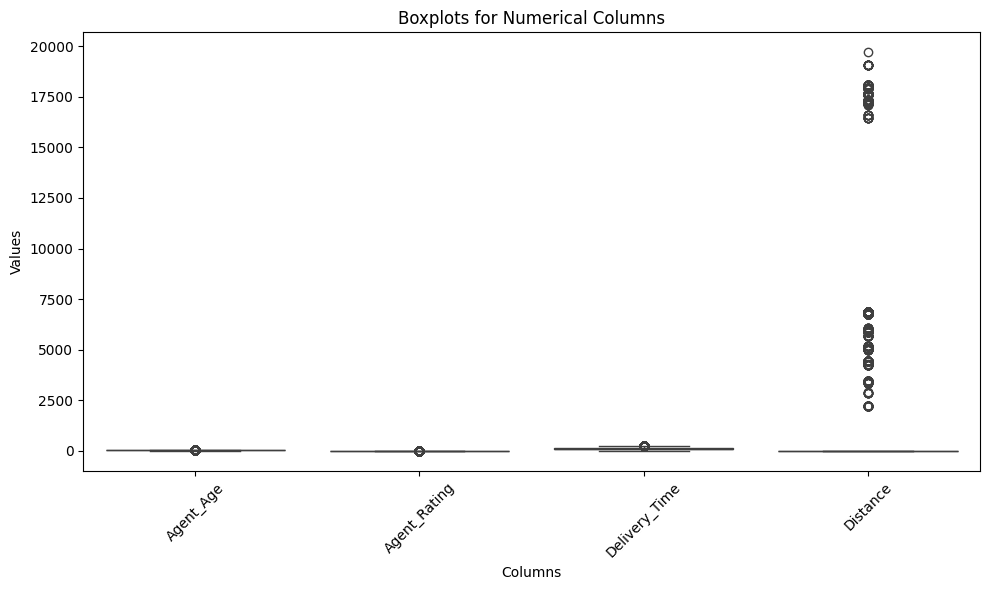

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

def draw_combined_boxplot(data, columns):
    # Select the numerical columns and convert to Pandas
    pandas_df = data.select(*columns).toPandas()
    
    # Melt the DataFrame to a long format suitable for Seaborn
    melted_df = pandas_df.melt(var_name="Variable", value_name="Value")
    
    # Plot the combined boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=melted_df, x="Variable", y="Value")
    plt.title("Boxplots for Numerical Columns")
    plt.xlabel("Columns")
    plt.ylabel("Values")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Numerical columns to visualize
numerical_cols = ["Agent_Age", "Agent_Rating", "Delivery_Time", "Distance"]

# Draw the combined boxplot
draw_combined_boxplot(data, numerical_cols)


In [28]:
# Save the original dataset before outlier handling
output_path_before = "amazon_delivery_before_outlier_handling.csv"  # Replace with your desired path
data.coalesce(1).write.csv(output_path_before, header=True,mode="overwrite")
print(f"Dataset saved before outlier handling at: {output_path_before}")


25/01/28 09:06:14 WARN TaskSetManager: Stage 54 contains a task of very large size (35857 KiB). The maximum recommended task size is 1000 KiB.


Dataset saved before outlier handling at: amazon_delivery_before_outlier_handling.csv


In [29]:
from pyspark.sql.functions import col

def remove_outliers(data, column):
    # Calculate the IQR and bounds
    quantiles = data.approxQuantile(column, [0.25, 0.75], 0.05)
    Q1, Q3 = quantiles
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter data to remove rows with outliers
    filtered_data = data.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))
    
    print(f"Rows remaining after removing outliers in {column}: {filtered_data.count()}")
    return filtered_data

# Apply outlier removal to all numerical columns
for col_name in numerical_cols:
    data = remove_outliers(data, col_name)

# Show the resulting dataset
data.show(5)

25/01/28 09:06:16 WARN TaskSetManager: Stage 55 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 09:06:18 WARN TaskSetManager: Stage 57 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


Rows remaining after removing outliers in Agent_Age: 217717


25/01/28 09:06:18 WARN TaskSetManager: Stage 60 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 09:06:19 WARN TaskSetManager: Stage 62 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


Rows remaining after removing outliers in Agent_Rating: 208235


25/01/28 09:06:20 WARN TaskSetManager: Stage 65 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 09:06:20 WARN TaskSetManager: Stage 67 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


Rows remaining after removing outliers in Delivery_Time: 202516


25/01/28 09:06:21 WARN TaskSetManager: Stage 70 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 09:06:21 WARN TaskSetManager: Stage 72 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


Rows remaining after removing outliers in Distance: 199871
+-------------+---------+------------+--------------+---------------+-------------+--------------+----------+----------+-------------------+----------+-------------+-----------+------------------+-----------+----------+------------+-----------+-------------+-------+----------+-------------+
|     Order_ID|Agent_Age|Agent_Rating|Store_Latitude|Store_Longitude|Drop_Latitude|Drop_Longitude|Order_Date|Order_Time|        Pickup_Time|   Weather|Delivery_Time|   Category|          Distance|Day_of_Week|Order_Hour|Order_Minute|Pickup_Hour|Pickup_Minute|Traffic|   Vehicle|         Area|
+-------------+---------+------------+--------------+---------------+-------------+--------------+----------+----------+-------------------+----------+-------------+-----------+------------------+-----------+----------+------------+-----------+-------------+-------+----------+-------------+
|ialx566343618|       37|         4.9|     22.745049|      75.892

25/01/28 09:06:22 WARN TaskSetManager: Stage 75 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


25/01/28 09:06:22 WARN TaskSetManager: Stage 76 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


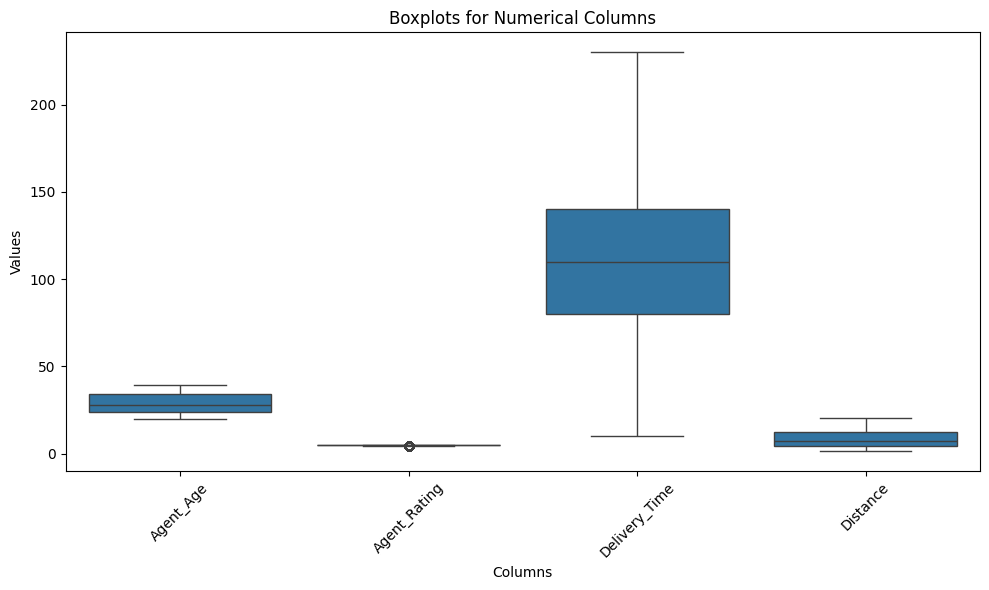

In [30]:
# Draw the combined boxplot
draw_combined_boxplot(data, numerical_cols)

In [31]:
# Save the dataset after flagging outliers
output_path_after = "cleaned_data.csv"  # Replace with your desired path
data.coalesce(1).write.csv(output_path_after, header=True,mode="overwrite")
print(f"Dataset saved after retaining outliers at: {output_path_after}")


25/01/28 09:06:24 WARN TaskSetManager: Stage 77 contains a task of very large size (35857 KiB). The maximum recommended task size is 1000 KiB.


Dataset saved after retaining outliers at: cleaned_data.csv


In [32]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.stat import Correlation, ChiSquareTest

25/01/28 09:06:27 WARN TaskSetManager: Stage 78 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 09:06:27 WARN TaskSetManager: Stage 79 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 09:06:28 WARN TaskSetManager: Stage 81 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 09:06:28 WARN TaskSetManager: Stage 82 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 09:06:30 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


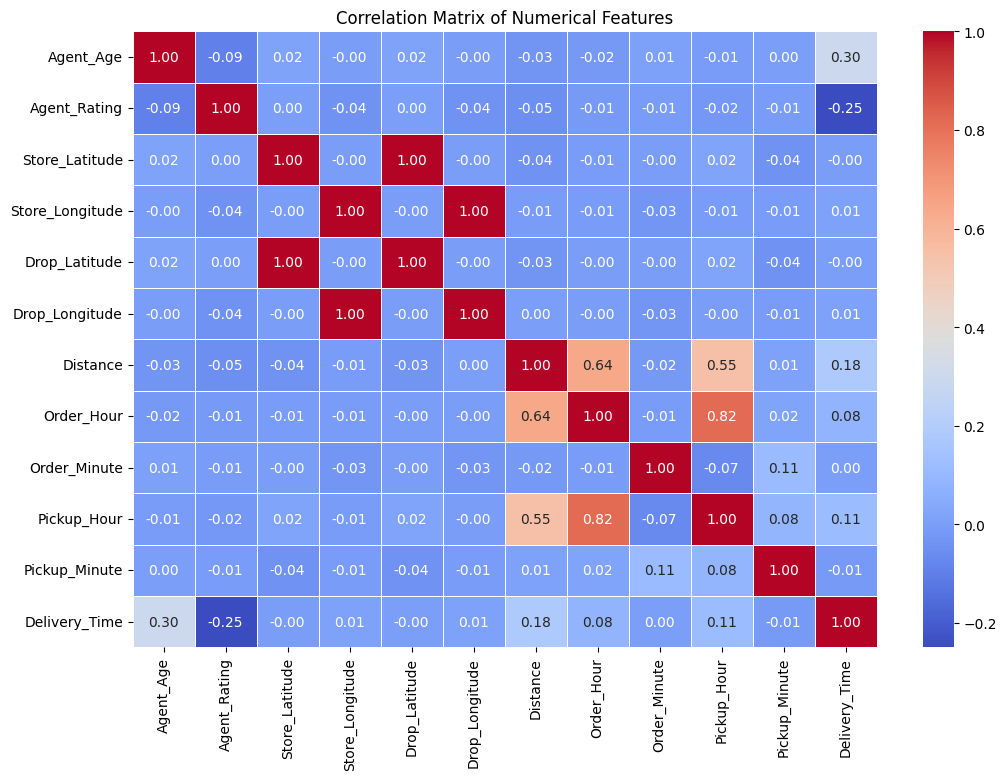

In [33]:
numerical_cols = ['Agent_Age', 'Agent_Rating', 'Store_Latitude', 
                  'Store_Longitude', 'Drop_Latitude', 'Drop_Longitude', 'Distance', "Order_Hour","Order_Minute","Pickup_Hour","Pickup_Minute", 'Delivery_Time']
# Assemble numerical columns into a single vector
assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")
vector_data = assembler.transform(data).select("features")

# Compute the correlation matrix
correlation_matrix = Correlation.corr(vector_data, "features").head()[0].toArray()

# # Convert correlation matrix to Pandas DataFrame for better readability
import pandas as pd
correlation_df = pd.DataFrame(
    correlation_matrix, 
    columns=numerical_cols, 
    index=numerical_cols
)

# Plot the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.show()


In [34]:
from pyspark.sql.functions import mean, col, count
from scipy.stats import f

def anova_all(df, categorical_cols, target_col):
    # Overall mean of the target column
    overall_mean = df.select(mean(target_col)).first()[0]
    results = {}
    for categorical_col in categorical_cols:
        # Group statistics by the categorical column
        grouped_stats = df.groupBy(categorical_col).agg(
            mean(target_col).alias('group_mean'),
            count(target_col).alias('group_count')
        )
        # Calculate Between-Group Sum of Squares (SSB)
        ssb = grouped_stats.withColumn(
            'ssb',
            (col('group_mean') - overall_mean) ** 2 * col('group_count')
        ).agg({'ssb': 'sum'}).first()[0]
        # Calculate Within-Group Sum of Squares (SSW)
        ssw = df.join(grouped_stats, on=categorical_col).withColumn(
            'ssw',
            (col(target_col) - col('group_mean')) ** 2
        ).agg({'ssw': 'sum'}).first()[0]
        # Degrees of freedom
        df_between = grouped_stats.count() - 1  # Number of groups - 1
        df_within = df.count() - grouped_stats.count()  # Total samples - number of groups
        # Calculate F-statistic
        ms_between = ssb / df_between if df_between != 0 else 0
        ms_within = ssw / df_within if df_within != 0 else 0
        f_statistic = ms_between / ms_within if ms_within != 0 else 0
        # Calculate p-value using scipy
        p_value = 1 - f.cdf(f_statistic, df_between, df_within) if df_within > 0 else 1
        # Store results
        results[categorical_col] = {
            'F-Statistic': f_statistic,
            'p-value': p_value,
            'df_between': df_between,
            'df_within': df_within
        }
    return results


# List of categorical columns and target column
categorical_cols = ["Weather", "Traffic", "Vehicle", "Area", "Category"]
target_col = "Delivery_Time"

# Perform ANOVA
anova_results = anova_all(data, categorical_cols, target_col)

# Display results
print("ANOVA Results:")
for feature, stats in anova_results.items():
    print(f"Feature: {feature}")
    print(f"  F-Statistic: {stats['F-Statistic']:.2f}")
    print(f"  p-value: {stats['p-value']:.14f}")
    print(f"  Degrees of Freedom (Between): {stats['df_between']}")
    print(f"  Degrees of Freedom (Within): {stats['df_within']}")
    print("\n")


25/01/28 09:06:31 WARN TaskSetManager: Stage 84 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 09:06:31 WARN TaskSetManager: Stage 87 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 09:06:33 WARN TaskSetManager: Stage 93 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 09:06:33 WARN TaskSetManager: Stage 94 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 09:06:35 WARN TaskSetManager: Stage 102 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 09:06:36 WARN TaskSetManager: Stage 108 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 09:06:36 WARN TaskSetManager: Stage 111 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/

ANOVA Results:
Feature: Weather
  F-Statistic: 2987.03
  p-value: 0.00000000000000
  Degrees of Freedom (Between): 5
  Degrees of Freedom (Within): 199865


Feature: Traffic
  F-Statistic: 6139.30
  p-value: 0.00000000000000
  Degrees of Freedom (Between): 3
  Degrees of Freedom (Within): 199867


Feature: Vehicle
  F-Statistic: 1786.51
  p-value: 0.00000000000000
  Degrees of Freedom (Between): 2
  Degrees of Freedom (Within): 199868


Feature: Area
  F-Statistic: 3564.65
  p-value: 0.00000000000000
  Degrees of Freedom (Between): 2
  Degrees of Freedom (Within): 199868


Feature: Category
  F-Statistic: 4287.08
  p-value: 0.00000000000000
  Degrees of Freedom (Between): 15
  Degrees of Freedom (Within): 199855




In [35]:
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

# Step 1: Define columns
numerical_cols = ['Agent_Age', 'Agent_Rating', 'Distance', 'Pickup_Hour']
categorical_cols = ["Weather", "Traffic", "Vehicle", "Area", "Category"]

# Step 2: Index categorical columns (convert strings to numbers)
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_Indexed") for col in categorical_cols]

# Step 3: One-hot encode categorical features (transform indexed labels to one-hot encoding)
encoders = [OneHotEncoder(inputCol=f"{col}_Indexed", outputCol=f"{col}_OneHot") for col in categorical_cols]

# Step 4: Assemble numerical and categorical features into a single vector
assembler = VectorAssembler(inputCols=numerical_cols + [f"{col}_OneHot" for col in categorical_cols], outputCol="features")

# Step 5: Apply transformations to the data (indexing, encoding, assembling)
pipeline_steps = indexers + encoders + [assembler]
pipeline = Pipeline(stages=pipeline_steps)
data_transformed = pipeline.fit(data).transform(data)

# Step 6: Split the data into training and test sets
train_data, test_data = data_transformed.randomSplit([0.8, 0.2], seed=42)

# Step 7: Scale numerical features for Linear Regression (only)
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
train_data_scaled = scaler.fit(train_data).transform(train_data)
test_data_scaled = scaler.fit(test_data).transform(test_data)

results=[]

25/01/28 09:06:51 WARN TaskSetManager: Stage 237 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 09:06:54 WARN TaskSetManager: Stage 240 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 09:06:54 WARN TaskSetManager: Stage 243 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 09:06:55 WARN TaskSetManager: Stage 246 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 09:06:56 WARN TaskSetManager: Stage 249 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 09:06:57 WARN TaskSetManager: Stage 252 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 09:07:01 WARN TaskSetManager: Stage 255 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.

In [36]:
# Step 8: Cross-Validation setup for Linear Regression with scaled features
lr = LinearRegression(featuresCol="scaled_features", labelCol="Delivery_Time")

# Define hyperparameter grid for Linear Regression
param_grid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()


# Setup evaluator and cross-validation
evaluator = RegressionEvaluator(labelCol="Delivery_Time", predictionCol="prediction", metricName="rmse")
cv_lr = CrossValidator(estimator=lr, estimatorParamMaps=param_grid_lr, evaluator=evaluator, numFolds=5)

# Fit Linear Regression with Cross-Validation
cv_model_lr = cv_lr.fit(train_data_scaled)

# Best model for Linear Regression
best_model_lr = cv_model_lr.bestModel

# Step 9: Predict and evaluate on test data for Linear Regression
predictions_lr = best_model_lr.transform(test_data_scaled)
rmse_lr = evaluator.evaluate(predictions_lr)
mae_lr = RegressionEvaluator(labelCol="Delivery_Time", predictionCol="prediction", metricName="mae").evaluate(predictions_lr)
r2_lr = RegressionEvaluator(labelCol="Delivery_Time", predictionCol="prediction", metricName="r2").evaluate(predictions_lr)

print("Linear Regression Performance (CV):")
print(f"RMSE: {rmse_lr:.3f}")
print(f"MAE: {mae_lr:.3f}")
print(f"R²: {r2_lr:.3f}")
results.append(("Linear Regression", rmse_lr, mae_lr, r2_lr))

25/01/28 09:07:03 WARN TaskSetManager: Stage 258 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 09:07:06 WARN TaskSetManager: Stage 259 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 09:07:07 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
25/01/28 09:07:08 WARN TaskSetManager: Stage 261 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 09:07:09 WARN TaskSetManager: Stage 263 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 09:07:10 WARN TaskSetManager: Stage 264 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 09:07:11 WARN TaskSetManager: Stage 266 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 09:07:11 WARN TaskSetM

Linear Regression Performance (CV):
RMSE: 29.962
MAE: 23.850
R²: 0.575


In [37]:
# Print the best model's hyperparameters
print("Best Model Hyperparameters:")
print(best_model_lr.extractParamMap())

Best Model Hyperparameters:
{Param(parent='LinearRegression_029a0d949461', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2, Param(parent='LinearRegression_029a0d949461', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LinearRegression_029a0d949461', name='epsilon', doc='The shape parameter to control the amount of robustness. Must be > 1.0. Only valid when loss is huber'): 1.35, Param(parent='LinearRegression_029a0d949461', name='featuresCol', doc='features column name.'): 'scaled_features', Param(parent='LinearRegression_029a0d949461', name='fitIntercept', doc='whether to fit an intercept term.'): True, Param(parent='LinearRegression_029a0d949461', name='labelCol', doc='label column name.'): 'Delivery_Time', Param(parent='LinearRegression_029a0d949461', name='loss', doc='The loss function to be optimized. Supported options: 

In [38]:
from pyspark.ml.regression import GBTRegressor

# Step 10: Cross-Validation setup for Gradient-Boosted Trees (GBT)
gbt = GBTRegressor(featuresCol="features", labelCol="Delivery_Time", maxIter=100, seed=42, validationTol=0.01)

param_grid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [3, 5, 7]) \
    .addGrid(gbt.maxIter, [10, 50, 100]) \
    .addGrid(gbt.stepSize, [0.01, 0.1, 0.3]) \
    .build()


# Setup cross-validation for GBT
cv_gbt = CrossValidator(estimator=gbt, estimatorParamMaps=param_grid_gbt, evaluator=evaluator, numFolds=5)

# Fit GBT with Cross-Validation
cv_model_gbt = cv_gbt.fit(train_data)

# Best model for GBT
best_model_gbt = cv_model_gbt.bestModel

# Step 11: Predict and evaluate on test data for GBT
predictions_gbt = best_model_gbt.transform(test_data)
rmse_gbt = evaluator.evaluate(predictions_gbt)
mae_gbt = RegressionEvaluator(labelCol="Delivery_Time", predictionCol="prediction", metricName="mae").evaluate(predictions_gbt)
r2_gbt = RegressionEvaluator(labelCol="Delivery_Time", predictionCol="prediction", metricName="r2").evaluate(predictions_gbt)

print("GBT Performance (CV):")
print(f"RMSE: {rmse_gbt:.3f}")
print(f"MAE: {mae_gbt:.3f}")
print(f"R²: {r2_gbt:.3f}")
results.append(("GBT", rmse_gbt, mae_gbt, r2_gbt))
# Print the best model's hyperparameters
print("Best Model Hyperparameters for GBT:")
print(best_model_gbt.extractParamMap())

# Optionally, print the GBT specific parameters like trees' information
print(f"Best Model MaxDepth: {best_model_gbt.getMaxDepth()}")
print(f"Best Model MaxIter: {best_model_gbt.getMaxIter()}")
print(f"Best Model StepSize: {best_model_gbt.getStepSize()}")

25/01/28 09:13:21 WARN TaskSetManager: Stage 548 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 09:13:27 WARN TaskSetManager: Stage 549 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 09:13:27 WARN TaskSetManager: Stage 550 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 09:13:28 WARN TaskSetManager: Stage 551 contains a task of very large size (3690 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 09:13:28 WARN TaskSetManager: Stage 553 contains a task of very large size (3690 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 09:13:30 WARN TaskSetManager: Stage 555 contains a task of very large size (3690 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 09:13:30 WARN TaskSetManager: Stage 557 contains a task of very large size (3690 KiB). The maximum recommended task size is 1000 KiB.

GBT Performance (CV):
RMSE: 12.090
MAE: 6.955
R²: 0.931
Best Model Hyperparameters for GBT:
{Param(parent='GBTRegressor_5ba4d05f0a2a', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False, Param(parent='GBTRegressor_5ba4d05f0a2a', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10, Param(parent='GBTRegressor_5ba4d05f0a2a', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'a

In [39]:
from pyspark.ml.regression import DecisionTreeRegressor

# Step 10: Cross-Validation setup for Decision Tree Regressor (DTR)
dtr = DecisionTreeRegressor(featuresCol="features", labelCol="Delivery_Time")

# Define hyperparameter grid for DTR
param_grid_dtr = ParamGridBuilder() \
    .addGrid(dtr.maxDepth, [5, 10, 20]) \
    .addGrid(dtr.minInstancesPerNode, [1, 5, 10]) \
    .build()

# Setup cross-validation for DTR
cv_dtr = CrossValidator(estimator=dtr, estimatorParamMaps=param_grid_dtr, evaluator=evaluator, numFolds=5)

# Fit DTR with Cross-Validation
cv_model_dtr = cv_dtr.fit(train_data)

# Best model for DTR
best_model_dtr = cv_model_dtr.bestModel

# Step 11: Predict and evaluate on test data for DTR
predictions_dtr = best_model_dtr.transform(test_data)
rmse_dtr = evaluator.evaluate(predictions_dtr)
mae_dtr = RegressionEvaluator(labelCol="Delivery_Time", predictionCol="prediction", metricName="mae").evaluate(predictions_dtr)
r2_dtr = RegressionEvaluator(labelCol="Delivery_Time", predictionCol="prediction", metricName="r2").evaluate(predictions_dtr)

print("Decision Tree Regressor Performance (CV):")
print(f"RMSE: {rmse_dtr:.3f}")
print(f"MAE: {mae_dtr:.3f}")
print(f"R²: {r2_dtr:.3f}")
results.append(("Decision Tree", rmse_dtr, mae_dtr, r2_dtr))

# Print the best model's hyperparameters
print("Best Model Hyperparameters for DTR:")
print(best_model_dtr.extractParamMap())

# Optionally, print DTR specific parameters like maxDepth and minInstancesPerNode
print(f"Best Model MaxDepth: {best_model_dtr.getMaxDepth()}")
print(f"Best Model MinInstancesPerNode: {best_model_dtr.getMinInstancesPerNode()}")

25/01/28 10:20:10 WARN TaskSetManager: Stage 74778 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 10:20:13 WARN TaskSetManager: Stage 74779 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 10:20:13 WARN TaskSetManager: Stage 74780 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 10:20:13 WARN TaskSetManager: Stage 74781 contains a task of very large size (3690 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 10:20:15 WARN TaskSetManager: Stage 74783 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 10:20:16 WARN TaskSetManager: Stage 74785 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 10:20:16 WARN TaskSetManager: Stage 74787 contains a task of very large size (3689 KiB). The maximum recommended task siz

Decision Tree Regressor Performance (CV):
RMSE: 11.017
MAE: 4.316
R²: 0.943
Best Model Hyperparameters for DTR:
{Param(parent='DecisionTreeRegressor_95b7ed4d5731', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False, Param(parent='DecisionTreeRegressor_95b7ed4d5731', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10, Param(parent='DecisionTreeRegressor_95b7ed4d5731', name='featuresCol', doc='features column name.'): 'features', Param(parent='DecisionTreeRegressor_95b7ed4d5731', name='impurity', doc='Cri

25/01/28 10:22:49 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


In [ ]:
# Step 10: Cross-Validation setup for Random Forest (without scaling)
rf = RandomForestRegressor(featuresCol="features", labelCol="Delivery_Time")

# Define hyperparameter grid for Random Forest (you can add more parameters to tune)
param_grid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50, 100]) \
    .addGrid(rf.maxDepth, [5, 10, 20]) \
    .build()


# Setup cross-validation for Random Forest
cv_rf = CrossValidator(estimator=rf, estimatorParamMaps=param_grid_rf, evaluator=evaluator, numFolds=5)

# Fit Random Forest with Cross-Validation
cv_model_rf = cv_rf.fit(train_data)

# Best model for Random Forest
best_model_rf = cv_model_rf.bestModel

# Step 11: Predict and evaluate on test data for Random Forest
predictions_rf = best_model_rf.transform(test_data)
rmse_rf = evaluator.evaluate(predictions_rf)
mae_rf = RegressionEvaluator(labelCol="Delivery_Time", predictionCol="prediction", metricName="mae").evaluate(predictions_rf)
r2_rf = RegressionEvaluator(labelCol="Delivery_Time", predictionCol="prediction", metricName="r2").evaluate(predictions_rf)

print("Random Forest Performance (CV):")
print(f"RMSE: {rmse_rf:.3f}")
print(f"MAE: {mae_rf:.3f}")
print(f"R²: {r2_rf:.3f}")
results.append(("Random Forest", rmse_rf, mae_rf, r2_rf))

# Get the best model from cross-validation
best_model_rf = cv_model_rf.bestModel

# Print the best model's hyperparameters
print("Best Model Hyperparameters for Random Forest:")
print(best_model_rf.extractParamMap())

In [41]:
print("Comparison of Models:")
print(f"{'Model':<25} {'RMSE':<10} {'MAE':<10} {'R²':<10}")
for name, rmse, mae, r2 in results:
    print(f"{name:<25} {rmse:<10.3f} {mae:<10.3f} {r2:<10.3f}")


Comparison of Models:
Model                     RMSE       MAE        R²        
Linear Regression         29.962     23.850     0.575     
GBT                       12.090     6.955      0.931     
Decision Tree             11.017     4.316      0.943     
Random Forest             9.377      4.872      0.958     


In [40]:
# Step 12: Evaluate Random Forest on Training Data
train_predictions_rf = best_model_rf.transform(train_data)
rmse_train_rf = evaluator.evaluate(train_predictions_rf)
mae_train_rf = RegressionEvaluator(labelCol="Delivery_Time", predictionCol="prediction", metricName="mae").evaluate(train_predictions_rf)
r2_train_rf = RegressionEvaluator(labelCol="Delivery_Time", predictionCol="prediction", metricName="r2").evaluate(train_predictions_rf)

print("Random Forest Performance (Training):")
print(f"Training RMSE: {rmse_train_rf:.3f}")
print(f"Training MAE: {mae_train_rf:.3f}")
print(f"Training R²: {r2_train_rf:.3f}")

# Compare Train vs Test Performance
print("Random Forest Train vs Test Comparison:")
print(f"Train RMSE: {rmse_train_rf:.3f}, Test RMSE: {rmse_rf:.3f}")
print(f"Train MAE: {mae_train_rf:.3f}, Test MAE: {mae_rf:.3f}")
print(f"Train R²: {r2_train_rf:.3f}, Test R²: {r2_rf:.3f}")

if rmse_train_rf < rmse_rf * 0.5:
    print("The model might be overfitting.")
elif abs(rmse_train_rf - rmse_rf) < (0.1 * rmse_train_rf):
    print("The model generalizes well.")
else:
    print("The model may need further tuning.")


25/01/23 17:01:59 WARN TaskSetManager: Stage 77384 contains a task of very large size (5580 KiB). The maximum recommended task size is 1000 KiB.
25/01/23 17:02:06 WARN TaskSetManager: Stage 77386 contains a task of very large size (5580 KiB). The maximum recommended task size is 1000 KiB.
25/01/23 17:02:10 WARN TaskSetManager: Stage 77388 contains a task of very large size (5580 KiB). The maximum recommended task size is 1000 KiB.


Random Forest Performance (Training):
Training RMSE: 7.556
Training MAE: 4.088
Training R²: 0.970
Random Forest Train vs Test Comparison:
Train RMSE: 7.556, Test RMSE: 9.521
Train MAE: 4.088, Test MAE: 4.965
Train R²: 0.970, Test R²: 0.952
The model may need further tuning.


Analyzing residuals for Linear Regression...
Descriptive Statistics of Residuals (Linear Regression):


25/01/28 15:17:25 WARN TaskSetManager: Stage 85118 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 15:17:31 WARN TaskSetManager: Stage 85121 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


+-------+------------------+
|summary|         Residuals|
+-------+------------------+
|  count|             39707|
|   mean|1.0372865298203169|
| stddev| 29.94404168748955|
|    min|-91.48914099100065|
|    max|122.72434767384689|
+-------+------------------+



<Figure size 1800x2000 with 0 Axes>

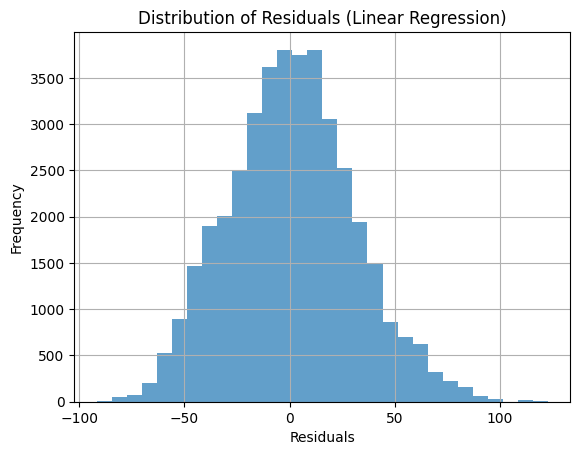

Analyzing residuals for GBT...
Descriptive Statistics of Residuals (GBT):


25/01/28 15:17:34 WARN TaskSetManager: Stage 85122 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+
|summary|          Residuals|
+-------+-------------------+
|  count|              39707|
|   mean|0.03521019786570108|
| stddev| 12.089601962811685|
|    min| -90.73123734171807|
|    max| 133.62225274689757|
+-------+-------------------+



25/01/28 15:17:37 WARN TaskSetManager: Stage 85125 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


<Figure size 1800x2000 with 0 Axes>

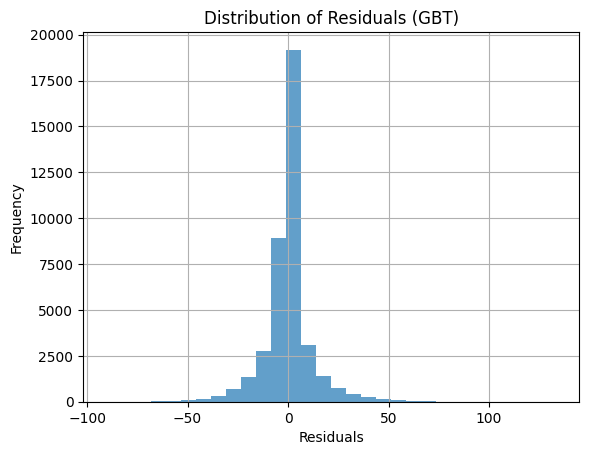

Analyzing residuals for Decision Tree...
Descriptive Statistics of Residuals (Decision Tree):


25/01/28 15:17:40 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
25/01/28 15:17:40 WARN TaskSetManager: Stage 85126 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+
|summary|          Residuals|
+-------+-------------------+
|  count|              39707|
|   mean|0.06949429088305595|
| stddev| 11.016559483971358|
|    min|             -140.0|
|    max|              135.0|
+-------+-------------------+



25/01/28 15:17:43 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
25/01/28 15:17:43 WARN TaskSetManager: Stage 85129 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


<Figure size 1800x2000 with 0 Axes>

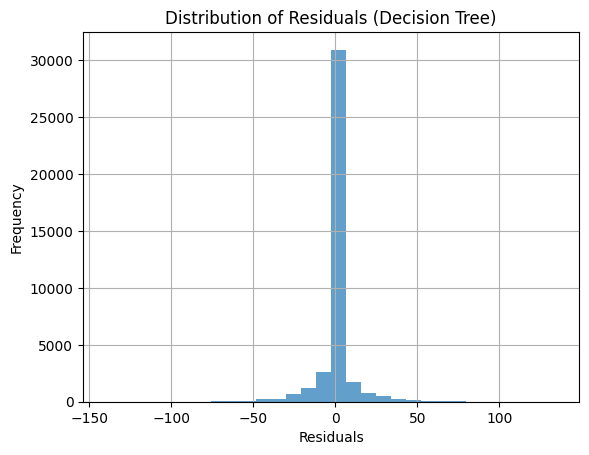

Analyzing residuals for Random Forest...
Descriptive Statistics of Residuals (Random Forest):


25/01/28 15:17:56 WARN TaskSetManager: Stage 85130 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+
|summary|           Residuals|
+-------+--------------------+
|  count|               39707|
|   mean|0.055220764529527434|
| stddev|   9.376549616445745|
|    min|  -92.13868254866051|
|    max|   80.69986606054562|
+-------+--------------------+



25/01/28 15:18:00 WARN TaskSetManager: Stage 85133 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


<Figure size 1800x2000 with 0 Axes>

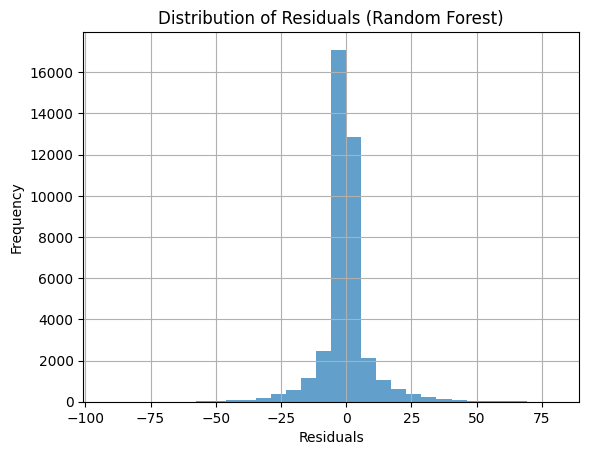

In [47]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Function to calculate and analyze residuals for a model
def analyze_residuals(model_name, predictions, labelCol="Delivery_Time"):
    # Calculate residuals
    residuals = predictions.withColumn("Residuals", col(labelCol) - col("prediction"))
    
    # Descriptive statistics
    print(f"Descriptive Statistics of Residuals ({model_name}):")
    residuals.select("Residuals").describe().show()
    
    # Convert residuals to Pandas for plotting
    residuals_pd = residuals.select("Residuals").toPandas()
    
    # Plot residuals distribution
    plt.figure(figsize=(8, 6))
    residuals_pd.plot(kind="hist", bins=30, title=f"Distribution of Residuals ({model_name})", alpha=0.7, legend=False)
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()


# Analyze residuals for all models
models = [
    ("Linear Regression", best_model_lr, test_data_scaled),
    ("GBT", best_model_gbt, test_data),
    ("Decision Tree", best_model_dtr, test_data),
    ("Random Forest", best_model_rf, test_data),
]

for model_name, model, data in models:
    print(f"Analyzing residuals for {model_name}...")
    predictions = model.transform(data)
    analyze_residuals(model_name, predictions)


In [45]:
# Function to save residuals to a CSV file
def save_residuals_to_csv(model_name, predictions, labelCol="Delivery_Time", file_path="residuals_{}.csv"):
    # Calculate residuals
    residuals = predictions.withColumn("Residuals", col(labelCol) - col("prediction"))
    
    # Save residuals to a CSV file
    file_name = file_path.format(model_name.replace(" ", "_").lower())
    residuals.select(labelCol, "prediction", "Residuals").write.csv(file_name, header=True, mode="overwrite")
    print(f"Residuals for {model_name} saved to {file_name}")


# Save residuals for all models
models = [
    ("Linear Regression", best_model_lr, test_data_scaled),
    ("GBT", best_model_gbt, test_data),
    ("Decision Tree", best_model_dtr, test_data),
    ("Random Forest", best_model_rf, test_data),
]

for model_name, model, data in models:
    print(f"Saving residuals for {model_name}...")
    predictions = model.transform(data)
    save_residuals_to_csv(model_name, predictions)


Saving residuals for Linear Regression...


25/01/28 15:03:55 WARN TaskSetManager: Stage 85098 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


Residuals for Linear Regression saved to residuals_linear_regression.csv
Saving residuals for GBT...


25/01/28 15:04:01 WARN TaskSetManager: Stage 85099 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


Residuals for GBT saved to residuals_gbt.csv
Saving residuals for Decision Tree...


25/01/28 15:04:03 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
25/01/28 15:04:03 WARN TaskSetManager: Stage 85100 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


Residuals for Decision Tree saved to residuals_decision_tree.csv
Saving residuals for Random Forest...


25/01/28 15:04:15 WARN TaskSetManager: Stage 85101 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


Residuals for Random Forest saved to residuals_random_forest.csv


In [45]:
# Function to save Actual vs Predicted data to CSV
def save_actual_vs_predicted_to_csv(model_name, predictions, labelCol="Delivery_Time", file_path="actual_vs_predicted_{}.csv"):
    # Select actual and predicted values
    actual_vs_predicted = predictions.select(labelCol, "prediction")
    
    # Save to CSV
    file_name = file_path.format(model_name.replace(" ", "_").lower())
    actual_vs_predicted.write.csv(file_name, header=True, mode="overwrite")
    print(f"Actual vs Predicted data for {model_name} saved to {file_name}")


# Save Actual vs Predicted data for all models
models = [
    ("Linear Regression", best_model_lr, test_data_scaled),
    ("GBT", best_model_gbt, test_data),
    ("Decision Tree", best_model_dtr, test_data),
    ("Random Forest", best_model_rf, test_data),
]

for model_name, model, data in models:
    print(f"Saving Actual vs Predicted data for {model_name}...")
    predictions = model.transform(data)
    save_actual_vs_predicted_to_csv(model_name, predictions)


Saving Actual vs Predicted data for Linear Regression...


25/01/27 19:16:44 WARN TaskSetManager: Stage 77558 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


Actual vs Predicted data for Linear Regression saved to actual_vs_predicted_linear_regression.csv
Saving Actual vs Predicted data for GBT...


25/01/27 19:16:47 WARN TaskSetManager: Stage 77559 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


Actual vs Predicted data for GBT saved to actual_vs_predicted_gbt.csv
Saving Actual vs Predicted data for Decision Tree...


25/01/27 19:16:51 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
25/01/27 19:16:51 WARN TaskSetManager: Stage 77560 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


Actual vs Predicted data for Decision Tree saved to actual_vs_predicted_decision_tree.csv
Saving Actual vs Predicted data for Random Forest...


25/01/27 19:17:04 WARN TaskSetManager: Stage 77561 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


Actual vs Predicted data for Random Forest saved to actual_vs_predicted_random_forest.csv


Plotting Actual vs Predicted for Linear Regression...


25/01/27 19:18:06 WARN TaskSetManager: Stage 77562 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


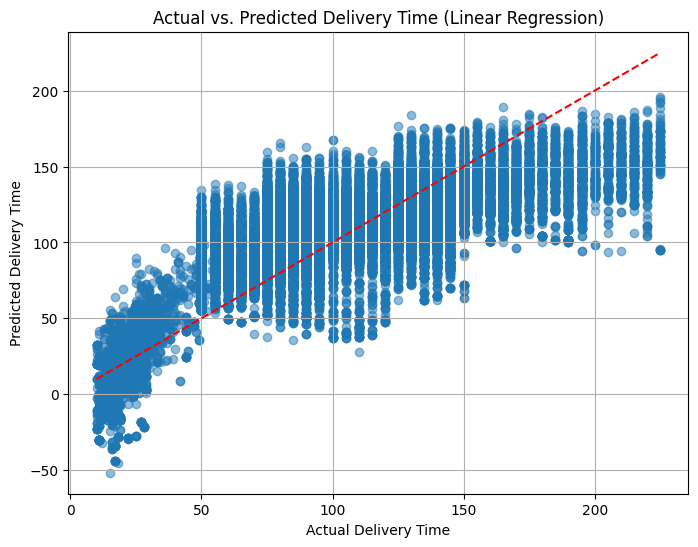

Plotting Actual vs Predicted for GBT...


25/01/27 19:18:09 WARN TaskSetManager: Stage 77563 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


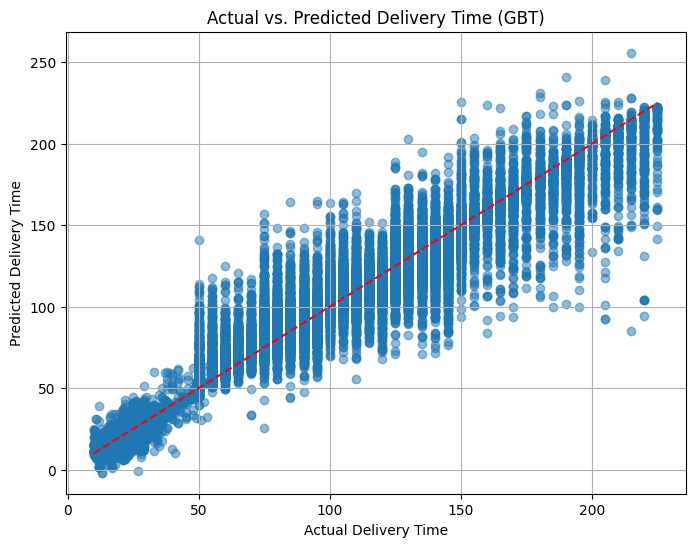

Plotting Actual vs Predicted for Decision Tree...


25/01/27 19:18:13 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
25/01/27 19:18:13 WARN TaskSetManager: Stage 77564 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


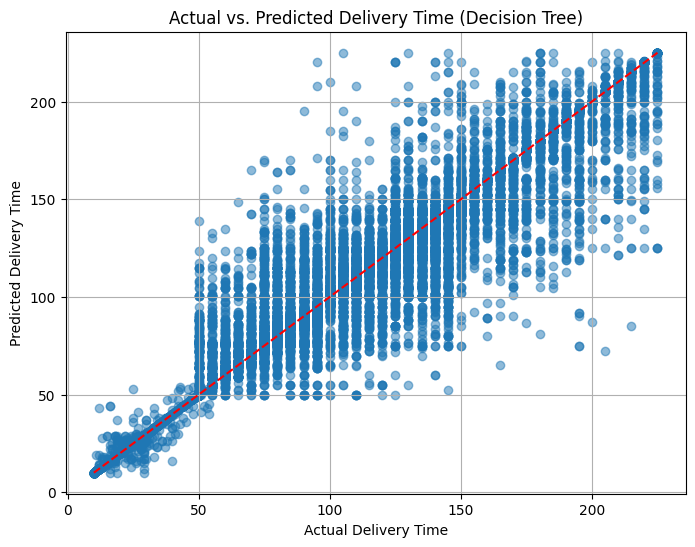

Plotting Actual vs Predicted for Random Forest...


25/01/27 19:18:26 WARN TaskSetManager: Stage 77565 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


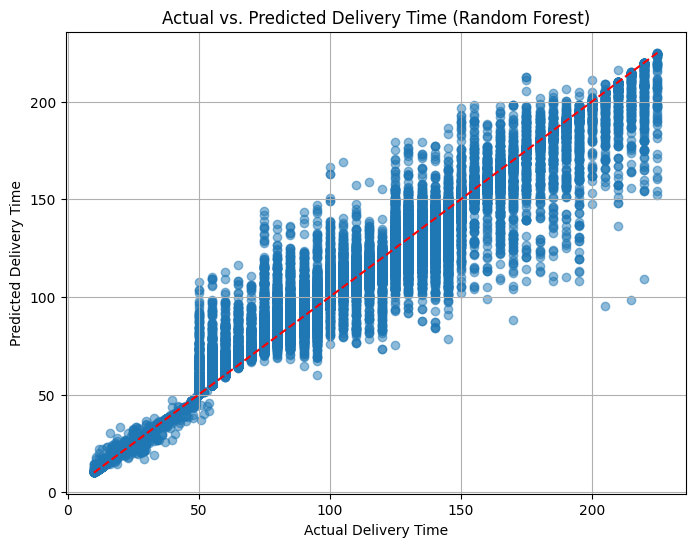

In [46]:
# Function to plot Actual vs Predicted
def plot_actual_vs_predicted(model_name, predictions, labelCol="Delivery_Time"):
    # Convert to Pandas for plotting
    predictions_pd = predictions.select(labelCol, "prediction").toPandas()
    
    # Scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(predictions_pd[labelCol], predictions_pd["prediction"], alpha=0.5)
    plt.plot([min(predictions_pd[labelCol]), max(predictions_pd[labelCol])], 
             [min(predictions_pd[labelCol]), max(predictions_pd[labelCol])], 
             color='red', linestyle='--')  # Line y=x
    plt.xlabel("Actual Delivery Time")
    plt.ylabel("Predicted Delivery Time")
    plt.title(f"Actual vs. Predicted Delivery Time ({model_name})")
    plt.grid()
    plt.show()


# Plot Actual vs Predicted for all models
for model_name, model, data in models:
    print(f"Plotting Actual vs Predicted for {model_name}...")
    predictions = model.transform(data)
    plot_actual_vs_predicted(model_name, predictions)


Calculating learning curve for Linear Regression...


25/01/28 13:06:29 WARN TaskSetManager: Stage 77538 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 13:06:32 WARN TaskSetManager: Stage 77540 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 13:06:34 WARN TaskSetManager: Stage 77542 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 13:06:35 WARN TaskSetManager: Stage 77544 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 13:06:36 WARN TaskSetManager: Stage 77546 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 13:06:37 WARN TaskSetManager: Stage 77548 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 13:06:38 WARN TaskSetManager: Stage 77550 contains a task of very large size (3689 KiB). The maximum recommended task siz

Learning curve data for Linear Regression saved to learning_curve_linear_regression.csv


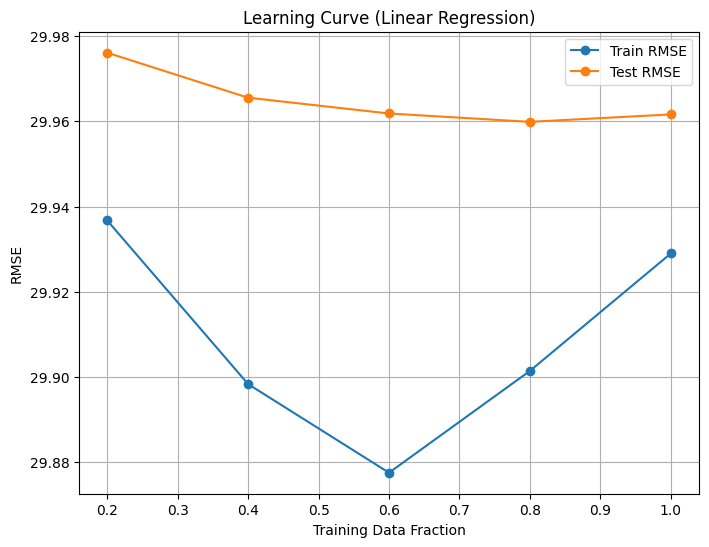

Calculating learning curve for GBT...


25/01/28 13:06:54 WARN TaskSetManager: Stage 77578 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 13:06:54 WARN TaskSetManager: Stage 77579 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 13:06:55 WARN TaskSetManager: Stage 77580 contains a task of very large size (3690 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 13:06:56 WARN TaskSetManager: Stage 77582 contains a task of very large size (3690 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 13:06:57 WARN TaskSetManager: Stage 77584 contains a task of very large size (3690 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 13:06:57 WARN TaskSetManager: Stage 77586 contains a task of very large size (3690 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 13:06:57 WARN TaskSetManager: Stage 77588 contains a task of very large size (3690 KiB). The maximum recommended task siz

Learning curve data for GBT saved to learning_curve_gbt.csv


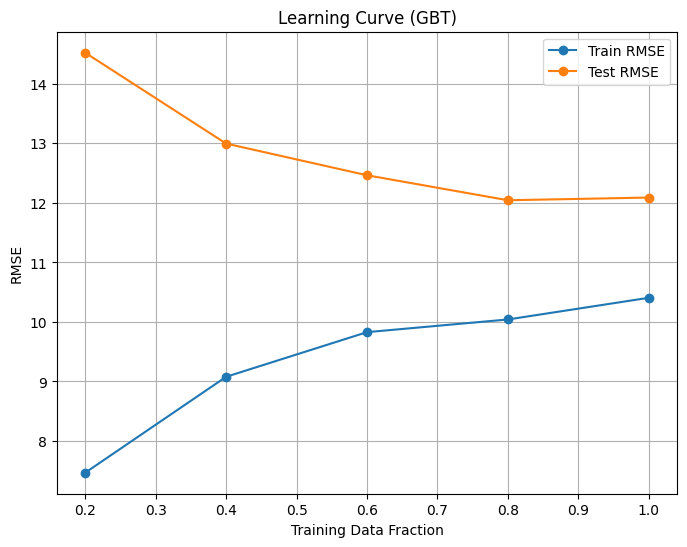

Calculating learning curve for Decision Tree...


25/01/28 13:20:53 WARN TaskSetManager: Stage 84618 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 13:20:53 WARN TaskSetManager: Stage 84619 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 13:20:55 WARN TaskSetManager: Stage 84620 contains a task of very large size (3690 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 13:20:56 WARN TaskSetManager: Stage 84622 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 13:20:58 WARN TaskSetManager: Stage 84624 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 13:20:58 WARN TaskSetManager: Stage 84626 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 13:20:58 WARN TaskSetManager: Stage 84628 contains a task of very large size (3689 KiB). The maximum recommended task siz

Learning curve data for Decision Tree saved to learning_curve_decision_tree.csv


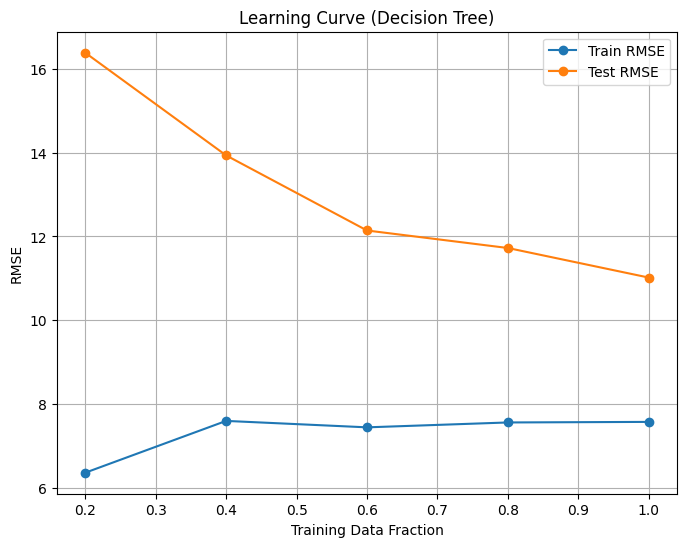

Calculating learning curve for Random Forest...


25/01/28 13:22:12 WARN TaskSetManager: Stage 84858 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 13:22:13 WARN TaskSetManager: Stage 84859 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 13:22:14 WARN TaskSetManager: Stage 84860 contains a task of very large size (3690 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 13:22:15 WARN TaskSetManager: Stage 84862 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 13:22:17 WARN TaskSetManager: Stage 84864 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 13:22:17 WARN TaskSetManager: Stage 84866 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 13:22:18 WARN TaskSetManager: Stage 84868 contains a task of very large size (3689 KiB). The maximum recommended task siz

Learning curve data for Random Forest saved to learning_curve_random_forest.csv


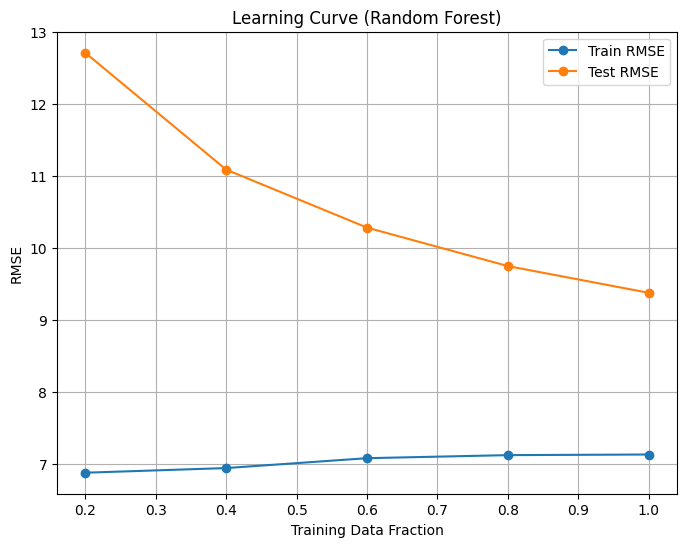

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor, DecisionTreeRegressor
from pyspark.ml.regression import LinearRegression

# Function to calculate and save learning curve data
def save_learning_curve_to_csv(model_name, model, train_data, test_data, labelCol="Delivery_Time", file_path="learning_curve_{}.csv"):
    evaluator = RegressionEvaluator(labelCol=labelCol, predictionCol="prediction", metricName="rmse")
    
    # Fraction of training data used for learning curve
    fractions = [0.2, 0.4, 0.6, 0.8, 1.0]
    train_rmse = []
    test_rmse = []
    
    for frac in fractions:
        # Sample training data
        sampled_train_data = train_data.sample(withReplacement=False, fraction=frac, seed=42)
        
        # Fit the model
        fitted_model = model.fit(sampled_train_data)
        
        # Evaluate RMSE on train and test data
        train_rmse.append(evaluator.evaluate(fitted_model.transform(sampled_train_data)))
        test_rmse.append(evaluator.evaluate(fitted_model.transform(test_data)))
    
    # Save learning curve data to CSV
    learning_curve_data = list(zip(fractions, train_rmse, test_rmse))
    file_name = file_path.format(model_name.replace(" ", "_").lower())
    pd.DataFrame(learning_curve_data, columns=["Fraction", "Train_RMSE", "Test_RMSE"]).to_csv(file_name, index=False)
    print(f"Learning curve data for {model_name} saved to {file_name}")
    
    # Plot learning curve
    plt.figure(figsize=(8, 6))
    plt.plot(fractions, train_rmse, label="Train RMSE", marker="o")
    plt.plot(fractions, test_rmse, label="Test RMSE", marker="o")
    plt.xlabel("Training Data Fraction")
    plt.ylabel("RMSE")
    plt.title(f"Learning Curve ({model_name})")
    plt.legend()
    plt.grid()
    plt.show()

# Define models with best parameters
models = [
    ("Linear Regression", LinearRegression(featuresCol="scaled_features", labelCol="Delivery_Time", maxIter=100, regParam=0.01, solver="auto"), train_data_scaled, test_data_scaled),
    ("GBT", GBTRegressor(featuresCol="features", labelCol="Delivery_Time", maxIter=100, stepSize=0.3, maxDepth=7, seed=42), train_data, test_data),
    ("Decision Tree", DecisionTreeRegressor(featuresCol="features", labelCol="Delivery_Time", maxDepth=20), train_data, test_data),
    ("Random Forest", RandomForestRegressor(featuresCol="features", labelCol="Delivery_Time", maxDepth=20, numTrees=100), train_data, test_data),
]

# Iterate over models and calculate learning curves
for model_name, model, train_data, test_data in models:
    print(f"Calculating learning curve for {model_name}...")
    save_learning_curve_to_csv(model_name, model, train_data, test_data)
